In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import subprocess
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from wordcloud import WordCloud

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from numpy import mean
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-16 18:38:31.481543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 18:38:31.481637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 18:38:31.620483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

# Preprocess dataset

In [2]:
regex_pattern = re.compile(r'[^a-zA-Z0-9\s]')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = regex_pattern.sub('', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return filtered_tokens

def preprocess_text_svm_rf(text):
    text = regex_pattern.sub('', text)
    text = text.lower()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(lemmatized_tokens)

df_svm_rf = pd.read_csv('../input/bigdata2023classification/train.csv', delimiter=',')
df_svm_rf['Content'] = df_svm_rf['Content'].apply(preprocess_text_svm_rf)

# Plot WordClouds

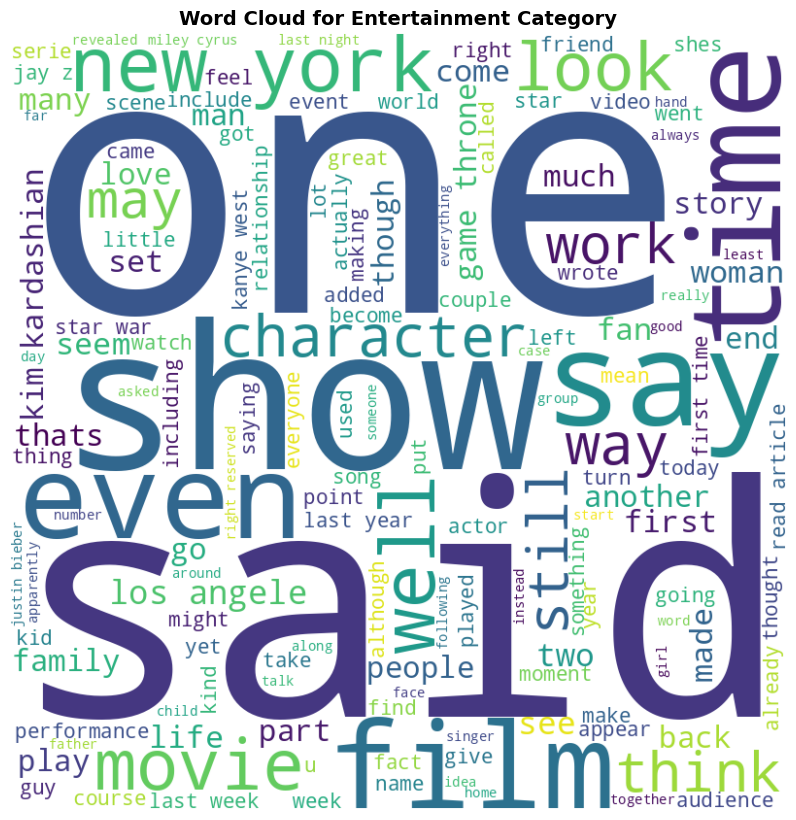

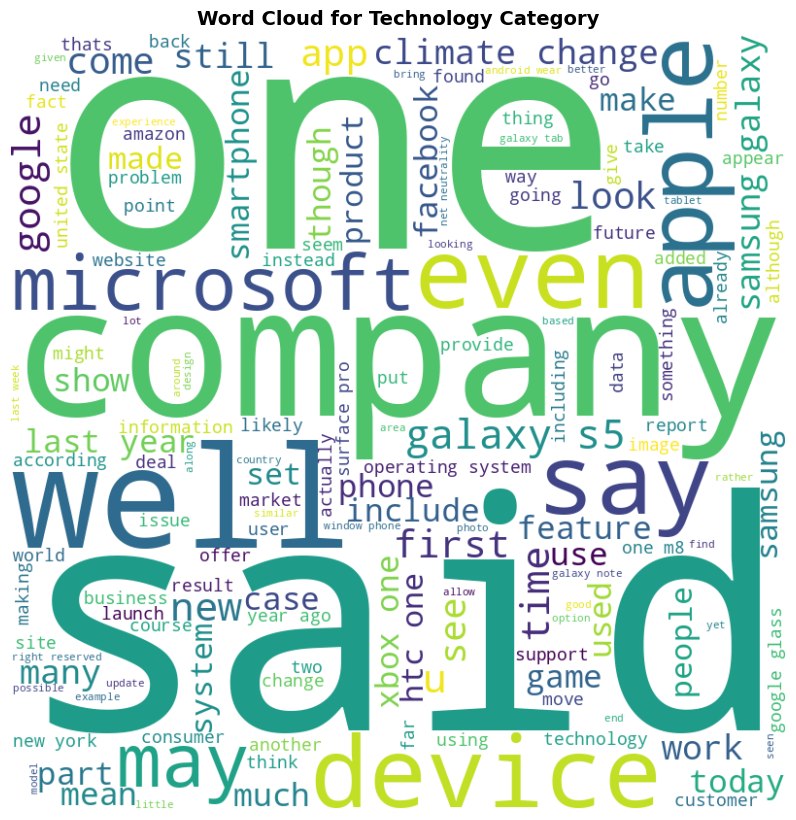

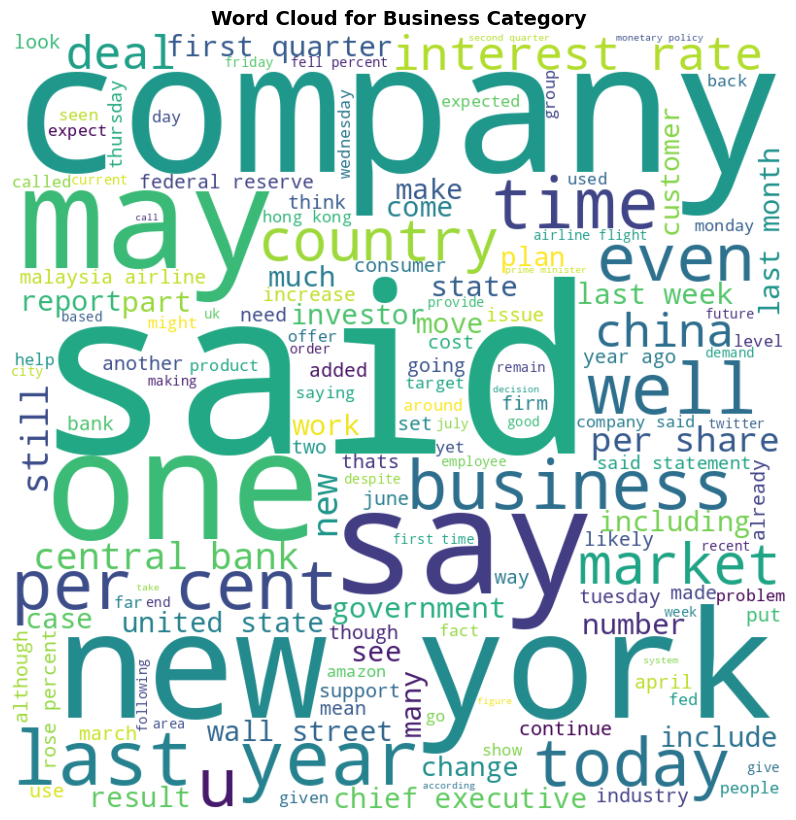

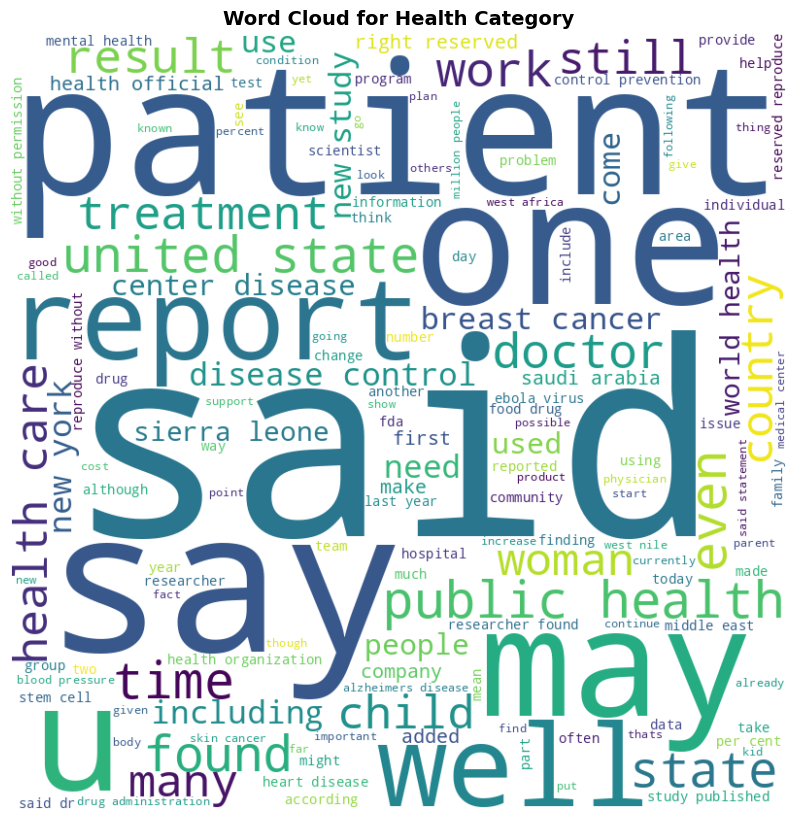

In [3]:
plt.style.use('ggplot')

for category in df_svm_rf['Label'].unique():
    texts = df_svm_rf[df_svm_rf['Label'] == category]['Content'].tolist()

    aggregated_text = " ".join(texts)

    wordcloud = WordCloud(width=800, height=800, 
                            background_color='white',
                            colormap='viridis',
                            max_words=150,
                            contour_color='steelblue',
                            contour_width=3).generate(aggregated_text)

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {category} Category", fontsize=14, fontweight='bold')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# SVM and Random Forest Pipelines

In [4]:
X = df_svm_rf['Content']
y = df_svm_rf['Label']

cv = KFold(n_splits=5, shuffle=True, random_state=42)

svm_bow_pipeline = Pipeline([
    ('vect', HashingVectorizer(n_features=2**14, alternate_sign=False)),
    ('clf', LinearSVC(dual=False))
])

rf_bow_pipeline = Pipeline([
    ('vect', HashingVectorizer(n_features=2**14, alternate_sign=False)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1))
])

svm_svd_pipeline = Pipeline([
    ('vect', HashingVectorizer(n_features=2**14, alternate_sign=False)),
    ('svd', TruncatedSVD(n_components=50)),
    ('clf', LinearSVC(dual=False))
])

rf_svd_pipeline = Pipeline([
    ('vect', HashingVectorizer(n_features=2**14, alternate_sign=False)),
    ('svd', TruncatedSVD(n_components=50)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1))
])

pipelines = {
    'SVM BOW': svm_bow_pipeline,
    'Random Forest BOW': rf_bow_pipeline,
    'SVM SVD': svm_svd_pipeline,
    'Random Forest SVD': rf_svd_pipeline
}

scoring = {'accuracy': 'accuracy',
           'precision': 'precision_macro',
           'recall': 'recall_macro'
}

for name, pipeline in pipelines.items():
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"\n{name}:")
    print("Accuracy: {:3f}".format(scores['test_accuracy'].mean()))
    print("Precision: {:3f}".format(scores['test_precision'].mean()))
    print("Recall: {:3f}".format(scores['test_recall'].mean()))



SVM BOW:
Accuracy: 0.964328
Precision: 0.962616
Recall: 0.959826

Random Forest BOW:
Accuracy: 0.750982
Precision: 0.852705
Recall: 0.671570

SVM SVD:
Accuracy: 0.892795
Precision: 0.886471
Recall: 0.871921

Random Forest SVD:
Accuracy: 0.880102
Precision: 0.880637
Recall: 0.849762


# Beat the Benchmark

In [5]:
df = pd.read_csv('../input/bigdata2023classification/train.csv', delimiter=',')
df['Content'] = df['Content'].apply(preprocess_text_svm_rf)

# Tokenizer learns the vocabulary of the dataset

In [6]:
NUM_WORDS = 10000 # max number of words in the vocabulary
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Content'])
sequences = tokenizer.texts_to_sequences(df['Content'])

# Tokenization

Average Sequence Length: 249
Maximum Sequence Length: 8400


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


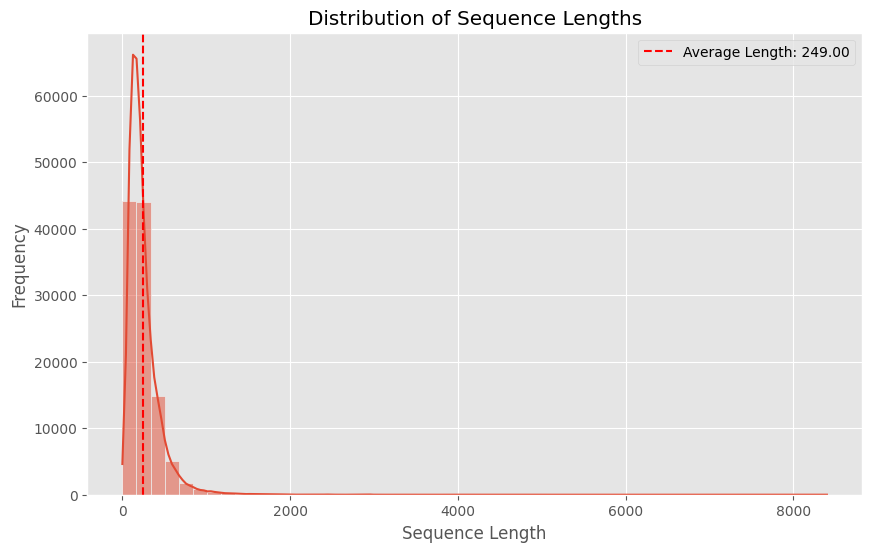

In [7]:
sequence_lengths = [len(x) for x in sequences]

max_seq_length = max(sequence_lengths)
average_length = int(mean(sequence_lengths))

print(f"Average Sequence Length: {average_length}")
print(f"Maximum Sequence Length: {max_seq_length}")

sequence_len = average_length # Average length of the sequences as sequence length for padding and truncating the sequences 

plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=50, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(x=average_length, color='r', linestyle='--', label=f'Average Length: {average_length:.2f}')
plt.legend()
plt.show()

# Label Encoding

In [8]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['Label'])
X_train, X_test, y_train, y_test = train_test_split(df['Content'], 
                                                    integer_encoded, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=integer_encoded)

# Data Generator

In [9]:
def data_generator(data, labels, batch_size, maxlen, tokenizer):
    num_samples = len(data)  
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_data = data[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            batch_sequences = tokenizer.texts_to_sequences(batch_data)
            batch_padded_sequences = pad_sequences(batch_sequences, maxlen=maxlen, padding='post', truncating='post')
            
            yield np.array(batch_padded_sequences), np.array(batch_labels)


# Model Structure

In [10]:
EMBEDDING_DIM = 200
LSTM_UNITS = 256
DROPOUT = 0.5
BATCH_SIZE = 32

def create_model(input_length, num_classes):
    model = Sequential([
        Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=input_length),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
        Dropout(DROPOUT),
        LSTM(LSTM_UNITS, return_sequences=False),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(sequence_len, len(np.unique(y_train)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 249, 200)          2000000   
                                                                 
 bidirectional (Bidirection  (None, 249, 512)          935936    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 249, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 4)                 1028      
                                                                 
Total params: 3724420 (14.21 MB)
Trainable params: 3724420 (14.21 MB)
Non-trainable params: 0 (0.00 Byte)
________________

# Model Train

In [11]:
train_generator = data_generator(X_train, y_train, BATCH_SIZE, sequence_len, tokenizer)
# all samples are used for training
steps_per_epoch = np.ceil(len(X_train) / BATCH_SIZE).astype(int)
validation_generator = data_generator(X_test, y_test, BATCH_SIZE, sequence_len, tokenizer)
# all samples are used for validation
num_test_steps = np.ceil(len(X_test) / BATCH_SIZE).astype(int)

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=num_test_steps,
                    epochs=10)


Epoch 1/10


I0000 00:00:1708110583.383164     235 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2795/2795 [==============================] - 237s 83ms/step - loss: 0.4867 - accuracy: 0.8117 - val_loss: 0.1644 - val_accuracy: 0.9435
Epoch 2/10
2795/2795 [==============================] - 161s 57ms/step - loss: 0.1329 - accuracy: 0.9564 - val_loss: 0.1406 - val_accuracy: 0.9552
Epoch 3/10
2795/2795 [==============================] - 161s 57ms/step - loss: 0.1004 - accuracy: 0.9673 - val_loss: 0.1355 - val_accuracy: 0.9547
Epoch 4/10
2795/2795 [==============================] - 161s 57ms/step - loss: 0.0798 - accuracy: 0.9737 - val_loss: 0.1447 - val_accuracy: 0.9564
Epoch 5/10
2795/2795 [==============================] - 161s 57ms/step - loss: 0.0637 - accuracy: 0.9790 - val_loss: 0.1356 - val_accuracy: 0.9593
Epoch 6/10
2795/2795 [==============================] - 161s 57ms/step - loss: 0.0509 - accuracy: 0.9834 - val_loss: 0.1487 - val_accuracy: 0.9597
Epoch 7/10
2795/2795 [==============================] - 161s 57ms/step - loss: 0.0399 - accuracy: 0.9865 - val_loss: 0.1590 - val

# Model Evaluation

In [12]:
predict_generator = data_generator(X_test, y_test, BATCH_SIZE, sequence_len, tokenizer)
# all samples are used for prediction
predict_steps = np.ceil(len(X_test) / BATCH_SIZE).astype(int)

predictions = model.predict(predict_generator, steps=predict_steps)
predicted_labels = predictions.argmax(axis=1)
print(classification_report(y_test, predicted_labels, target_names=label_encoder.classes_))

precision, recall, _, _ = precision_recall_fscore_support(y_test, predicted_labels, average='macro')
accuracy = accuracy_score(y_test, predicted_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro): {precision:.2f}")
print(f"Recall (Macro): {recall:.2f}")


699/699 [==============================] - 16s 21ms/step
               precision    recall  f1-score   support

     Business       0.92      0.94      0.93      4967
Entertainment       0.98      0.98      0.98      8967
       Health       0.96      0.97      0.96      2404
   Technology       0.95      0.94      0.94      6021

     accuracy                           0.96     22359
    macro avg       0.95      0.96      0.95     22359
 weighted avg       0.96      0.96      0.96     22359

Accuracy: 0.96
Precision (Macro): 0.95
Recall (Macro): 0.96


# Confusion Matrix

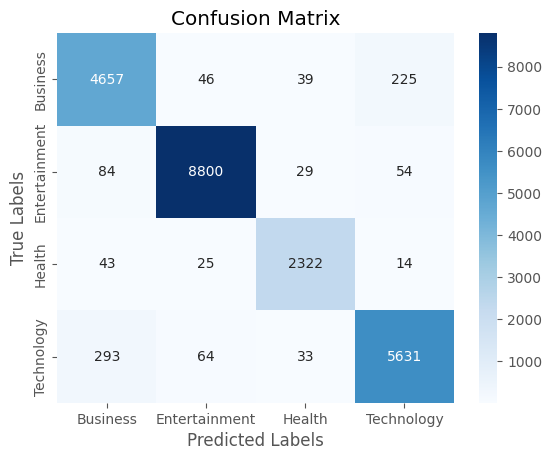

In [13]:
conf_mat = confusion_matrix(y_test, predicted_labels)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Training and Validation Accuracy/Loss over-time

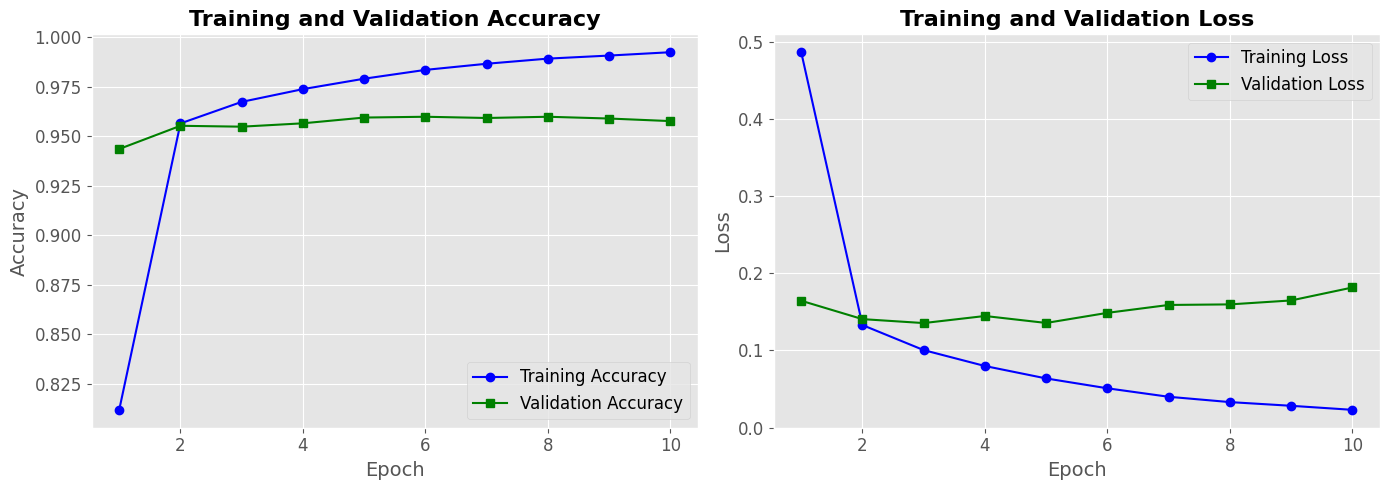

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'gs-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'gs-', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Predict test dataset

In [15]:
test_df = pd.read_csv('../input/bigdata2023classification/test_without_labels.csv', delimiter=',')
test_df['Content'] = test_df['Content'].apply(preprocess_text)

test_sequences = tokenizer.texts_to_sequences(test_df['Content'])

test_padded = pad_sequences(test_sequences, maxlen=sequence_len, padding='post', truncating='post')

test_predictions = model.predict(test_padded)
test_predicted_labels = test_predictions.argmax(axis=1)
predicted_label_names = label_encoder.inverse_transform(test_predicted_labels)
predictions_df = pd.DataFrame({
    'Id': test_df['Id'],
    'Predicted': predicted_label_names})
predictions_df.to_csv('testSet_categories.csv', index=False)


1498/1498 [==============================] - 33s 22ms/step


# Optuna optimization commented code

In [16]:
# def objective(trial):
#     num_units = trial.suggest_categorical('num_units', [64, 128, 256])
#     dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
#     optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
#     # num_lstm_layers = trial.suggest_categorical('num_lstm_layers', [1, 2])
#     num_lstm_layers = 2
#     batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
#     # epochs = trial.suggest_categorical('epochs', [10])
#     epochs = 10
#     embedding_dim = trial.suggest_categorical('embedding_dim', [100, 200, 300])
    
#     model = Sequential()
#     model.add(Embedding(input_dim=NUM_WORDS, output_dim=embedding_dim, input_length=sequence_len))
#     for _ in range(num_lstm_layers):
#         model.add(Bidirectional(LSTM(num_units, return_sequences=True if _ < num_lstm_layers - 1 else False)))
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(len(np.unique(integer_encoded)), activation='softmax'))
    
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     X_train, X_val, y_train, y_val = train_test_split(df['Content'], integer_encoded, test_size=0.2, random_state=42, stratify=integer_encoded)

#     train_generator = data_generator(X_train, y_train, batch_size, sequence_len, tokenizer)
#     validation_generator = data_generator(X_val, y_val, batch_size, sequence_len, tokenizer)

#     steps_per_epoch = np.ceil(len(X_train) / batch_size).astype(int)
#     validation_steps = np.ceil(len(X_val) / batch_size).astype(int)

#     history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
#                         validation_data=validation_generator, validation_steps=validation_steps, verbose=1)
    
#     best_val_acc = max(history.history['val_accuracy'])
#     return best_val_acc

# study = optuna.create_study(direction='maximize')

# study.optimize(objective, n_trials=10)

# best_params = study.best_params
# best_score = study.best_value
# print(f"Best parameters: {best_params}\nBest score: {best_score}")

# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_param_importances(study)